In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# training_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - Images from Dellaire Lab/input/set/training_set'
# test_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - Images from Dellaire Lab/input/set/test_set'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
training_path = '/content/drive/MyDrive/set/training_set'
test_path = '/content/drive/MyDrive/set/test_set'

val_path = '/content/drive/MyDrive/set/validation_set'

In [5]:
train_dataset = datasets.ImageFolder(training_path,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))
test_dataset = datasets.ImageFolder(test_path,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))
val_dataset = datasets.ImageFolder(val_path,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
print(train_dataset.class_to_idx)

{'arsenic': 0, 'non_arsenic': 1}


In [7]:
print(f"Number of batches in train_loader: {len(train_dataset)}")
print(f"Number of batches in val_loader: {len(val_dataset)}")
print(f"Number of batches in test_loader: {len(test_dataset)}")




Number of batches in train_loader: 100
Number of batches in val_loader: 40
Number of batches in test_loader: 20


### Using Pretrained Model

In [8]:


from torchvision import models, datasets, transforms

In [9]:
# Load pretrained ResNet-50
model_pre = models.resnet18(pretrained=True)

# Modify the fully connected layer to match the number of classes in your dataset
num_classes = 2  # Number of classes
# model_pre.fc = nn.Linear(in_features=model_pre.fc.in_features, out_features=num_classes)
model_pre.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout with 50% probability
    nn.Linear(in_features=model_pre.fc.in_features, out_features=num_classes)
)
# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pre = model_pre.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


In [10]:
# # Check the input features of the final fully connected layer (model.fc)
# print(f"Original FC input features: {model_pre.fc.in_features}")
# print(model_pre)  # This will print out the full architecture and you can verify the number of features in the final layer


In [11]:

from torch.optim import lr_scheduler
# Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pre.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Optimizer
# optimizer = torch.optim.Adam(model_pre.parameters(), lr=0.01)

# # Learning rate scheduler
# # Reduce learning rate when a metric has stopped improving (e.g., validation loss)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)



In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [13]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import torch

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Lists to track evaluation metrics over all epochs
val_precision_history = []
val_recall_history = []
val_f1_history = []
val_roc_auc_history = []
val_dice_history = []

num_epochs = 20
# patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
# patience_counter = 0

for epoch in range(num_epochs):
    # Training phase
    model_pre.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_pre(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation phase
    model_pre.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_all_labels = []
    val_all_preds = []
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_pre(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            _, val_predicted = val_outputs.max(1)
            val_correct += val_predicted.eq(val_labels).sum().item()
            val_total += val_labels.size(0)

            val_all_labels.extend(val_labels.cpu().numpy())
            val_all_preds.extend(val_predicted.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Calculate additional metrics after validation phase
    val_precision = precision_score(val_all_labels, val_all_preds, average='binary')
    val_recall = recall_score(val_all_labels, val_all_preds, average='binary')
    val_f1 = f1_score(val_all_labels, val_all_preds, average='binary')
    val_roc_auc = roc_auc_score(val_all_labels, val_all_preds)
    # Dice Coefficient
    val_intersection = sum([1 for true, pred in zip(val_all_labels, val_all_preds) if true == pred == 1])
    val_union = sum([1 for true in val_all_labels if true == 1]) + sum([1 for pred in val_all_preds if pred == 1])
    val_dice = 2 * val_intersection / (val_union + val_intersection)

    # Store the metrics for averaging later
    val_precision_history.append(val_precision)
    val_recall_history.append(val_recall)
    val_f1_history.append(val_f1)
    val_roc_auc_history.append(val_roc_auc)
    val_dice_history.append(val_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, "
          f"Val F1: {val_f1:.4f}, Val ROC AUC: {val_roc_auc:.4f}, Val Dice: {val_dice:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_pre.state_dict()  # Save the best model
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered.")
    #         break



Epoch [1/20] - Train Loss: 0.6134, Train Acc: 66.00%, Val Loss: 0.6798, Val Acc: 62.50%, Val Precision: 0.8571, Val Recall: 0.3000, Val F1: 0.4444, Val ROC AUC: 0.6250, Val Dice: 0.3636
Epoch [2/20] - Train Loss: 0.0774, Train Acc: 100.00%, Val Loss: 0.6382, Val Acc: 75.00%, Val Precision: 0.7778, Val Recall: 0.7000, Val F1: 0.7368, Val ROC AUC: 0.7500, Val Dice: 0.5385
Epoch [3/20] - Train Loss: 0.0887, Train Acc: 100.00%, Val Loss: 0.6249, Val Acc: 75.00%, Val Precision: 1.0000, Val Recall: 0.5000, Val F1: 0.6667, Val ROC AUC: 0.7500, Val Dice: 0.5000
Epoch [4/20] - Train Loss: 0.3401, Train Acc: 98.00%, Val Loss: 0.8430, Val Acc: 55.00%, Val Precision: 1.0000, Val Recall: 0.1000, Val F1: 0.1818, Val ROC AUC: 0.5500, Val Dice: 0.1667
Epoch [5/20] - Train Loss: 0.0929, Train Acc: 98.00%, Val Loss: 1.0472, Val Acc: 52.50%, Val Precision: 1.0000, Val Recall: 0.0500, Val F1: 0.0952, Val ROC AUC: 0.5250, Val Dice: 0.0909
Epoch [6/20] - Train Loss: 0.0329, Train Acc: 98.00%, Val Loss: 1.01

In [14]:
# Load the best model state
model_pre.load_state_dict(best_model_state)

# Compute average metrics over all epochs
avg_val_precision = sum(val_precision_history) / len(val_precision_history)
avg_val_recall = sum(val_recall_history) / len(val_recall_history)
avg_val_f1 = sum(val_f1_history) / len(val_f1_history)
avg_val_roc_auc = sum(val_roc_auc_history) / len(val_roc_auc_history)
avg_val_dice = sum(val_dice_history) / len(val_dice_history)

# Print the average evaluation metrics for the validation dataset
print("\nAverage Validation Metrics over All Epochs:")
print(f"Avg Precision: {avg_val_precision:.4f}")
print(f"Avg Recall: {avg_val_recall:.4f}")
print(f"Avg F1-score: {avg_val_f1:.4f}")
print(f"Avg ROC AUC: {avg_val_roc_auc:.4f}")
print(f"Avg Dice Coefficient: {avg_val_dice:.4f}")

# Testing phase
model_pre.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
test_all_labels = []
test_all_preds = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model_pre(test_inputs)
        test_loss += criterion(test_outputs, test_labels).item()
        _, test_predicted = test_outputs.max(1)
        test_correct += test_predicted.eq(test_labels).sum().item()
        test_total += test_labels.size(0)

        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_preds.extend(test_predicted.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = 100.0 * test_correct / test_total

# Calculate additional metrics after testing phase
test_precision = precision_score(test_all_labels, test_all_preds, average='binary')
test_recall = recall_score(test_all_labels, test_all_preds, average='binary')
test_f1 = f1_score(test_all_labels, test_all_preds, average='binary')
test_roc_auc = roc_auc_score(test_all_labels, test_all_preds)
# Dice Coefficient
test_intersection = sum([1 for true, pred in zip(test_all_labels, test_all_preds) if true == pred == 1])
test_union = sum([1 for true in test_all_labels if true == 1]) + sum([1 for pred in test_all_preds if pred == 1])
test_dice = 2 * test_intersection / (test_union + test_intersection)

print(f"\nTest Set - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%, "
      f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, "
      f"Test F1: {test_f1:.4f}, Test ROC AUC: {test_roc_auc:.4f}, Test Dice: {test_dice:.4f}")



Average Validation Metrics over All Epochs:
Avg Precision: 0.9817
Avg Recall: 0.7350
Avg F1-score: 0.7775
Avg ROC AUC: 0.8613
Avg Dice Coefficient: 0.5371

Test Set - Loss: 0.0169, Accuracy: 100.00%, Test Precision: 1.0000, Test Recall: 1.0000, Test F1: 1.0000, Test ROC AUC: 1.0000, Test Dice: 0.6667


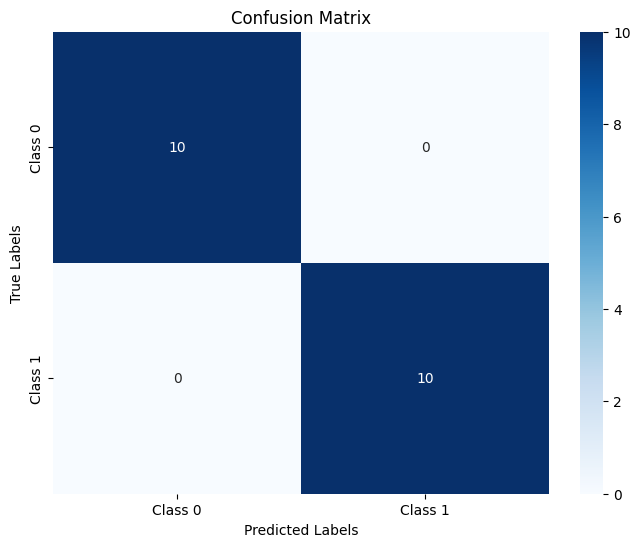

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# After the testing phase, calculate the confusion matrix
test_all_labels = []
test_all_preds = []

# Collect all true labels and predictions
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model_pre(test_inputs)
        _, test_predicted = test_outputs.max(1)

        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_preds.extend(test_predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(test_all_labels, test_all_preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [16]:
# Function to plot ROC curve
import matplotlib.pyplot as plt
def plot_roc_curve(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability for the positive class
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(probs.cpu().numpy())

    # Compute ROC curve and ROC AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


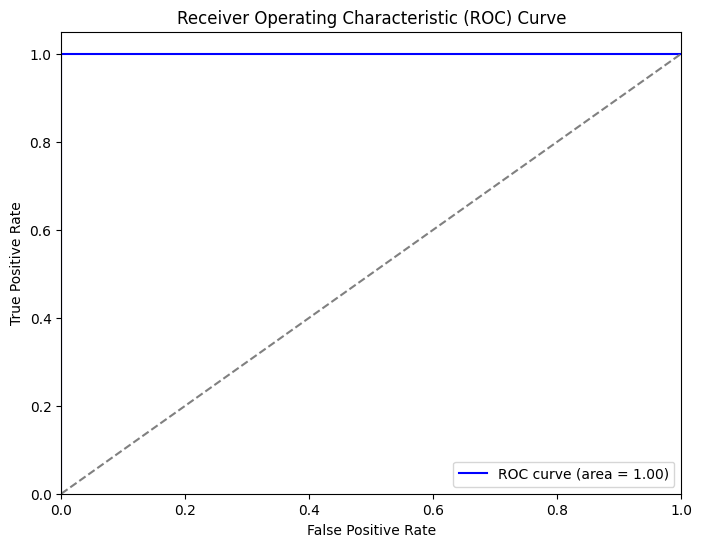

In [17]:
plot_roc_curve(model_pre, test_loader)

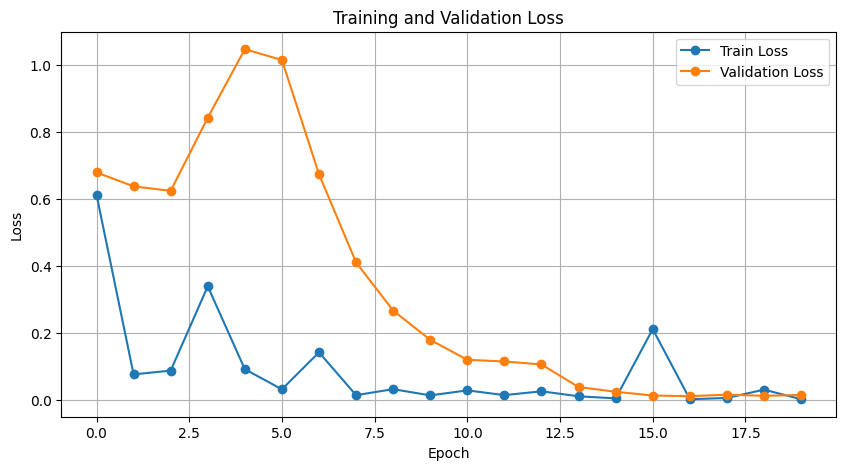

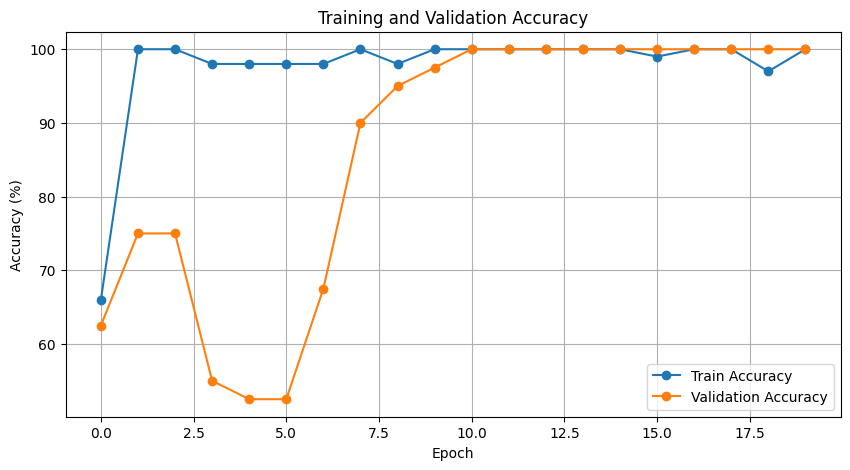

In [18]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()


In [19]:
# for param in model_pre.layer1.parameters():
#     param.requires_grad = False

In [20]:
# optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, model_pre.parameters()), lr=0.001
# )


In [21]:
# # Example training loop with testing on the test set
# train_loss_history = []
# train_acc_history = []
# val_loss_history = []
# val_acc_history = []
# num_epochs = 20
# for epoch in range(num_epochs):
#     # Training phase
#     model_pre.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model_pre(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = outputs.max(1)
#         correct += predicted.eq(labels).sum().item()
#         total += labels.size(0)

#     train_loss = running_loss / len(train_loader)
#     train_acc = 100.0 * correct / total
#     train_loss_history.append(train_loss)
#     train_acc_history.append(train_acc)

#     # Validation phase
#     model_pre.eval()
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for val_inputs, val_labels in val_loader:
#             val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
#             val_outputs = model_pre(val_inputs)
#             val_loss += criterion(val_outputs, val_labels).item()
#             _, val_predicted = val_outputs.max(1)
#             val_correct += val_predicted.eq(val_labels).sum().item()
#             val_total += val_labels.size(0)

#     val_loss = val_loss / len(val_loader)
#     val_acc = 100.0 * val_correct / val_total
#     val_loss_history.append(val_loss)
#     val_acc_history.append(val_acc)

#     print(f"Epoch [{epoch+1}/{num_epochs}] - "
#           f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#           f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# # Testing phase
# model_pre.eval()
# test_loss = 0.0
# test_correct = 0
# test_total = 0
# with torch.no_grad():
#     for test_inputs, test_labels in test_loader:
#         test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
#         test_outputs = model_pre(test_inputs)
#         test_loss += criterion(test_outputs, test_labels).item()
#         _, test_predicted = test_outputs.max(1)
#         test_correct += test_predicted.eq(test_labels).sum().item()
#         test_total += test_labels.size(0)

# test_loss = test_loss / len(test_loader)
# test_acc = 100.0 * test_correct / test_total

# print(f"\nTest Set - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")


In [22]:
# import matplotlib.pyplot as plt

# # Plot Loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_loss_history, label="Train Loss", marker='o')
# plt.plot(val_loss_history, label="Validation Loss", marker='o')
# plt.title("Loss Curve")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot Accuracy
# plt.figure(figsize=(10, 5))
# plt.plot(train_acc_history, label="Train Accuracy", marker='o')
# plt.plot(val_acc_history, label="Validation Accuracy", marker='o')
# plt.title("Accuracy Curve")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy (%)")
# plt.legend()
# plt.grid(True)
# plt.show()


In [23]:
# # Freeze Layer 2 (e.g., 'layer2') - Do not update these parameters during training
# for param in model_pre.layer2.parameters():
#     param.requires_grad = False

# # Unfreeze Layer 1 (e.g., 'layer1') - Allow these parameters to be updated during training
# for param in model_pre.layer1.parameters():
#     param.requires_grad = True


In [24]:
# optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, model_pre.parameters()), lr=0.001
# )


In [25]:
# # Example training loop with testing on the test set
# train_loss_history = []
# train_acc_history = []
# val_loss_history = []
# val_acc_history = []
# num_epochs = 20
# for epoch in range(num_epochs):
#     # Training phase
#     model_pre.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model_pre(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = outputs.max(1)
#         correct += predicted.eq(labels).sum().item()
#         total += labels.size(0)

#     train_loss = running_loss / len(train_loader)
#     train_acc = 100.0 * correct / total
#     train_loss_history.append(train_loss)
#     train_acc_history.append(train_acc)

#     # Validation phase
#     model_pre.eval()
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for val_inputs, val_labels in val_loader:
#             val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
#             val_outputs = model_pre(val_inputs)
#             val_loss += criterion(val_outputs, val_labels).item()
#             _, val_predicted = val_outputs.max(1)
#             val_correct += val_predicted.eq(val_labels).sum().item()
#             val_total += val_labels.size(0)

#     val_loss = val_loss / len(val_loader)
#     val_acc = 100.0 * val_correct / val_total
#     val_loss_history.append(val_loss)
#     val_acc_history.append(val_acc)

#     print(f"Epoch [{epoch+1}/{num_epochs}] - "
#           f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#           f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# # Testing phase
# model_pre.eval()
# test_loss = 0.0
# test_correct = 0
# test_total = 0
# with torch.no_grad():
#     for test_inputs, test_labels in test_loader:
#         test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
#         test_outputs = model_pre(test_inputs)
#         test_loss += criterion(test_outputs, test_labels).item()
#         _, test_predicted = test_outputs.max(1)
#         test_correct += test_predicted.eq(test_labels).sum().item()
#         test_total += test_labels.size(0)

# test_loss = test_loss / len(test_loader)
# test_acc = 100.0 * test_correct / test_total

# print(f"\nTest Set - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")


In [26]:
# # Freeze Layer 2 (e.g., 'layer3') - Do not update these parameters during training
# for param in model_pre.layer3.parameters():
#     param.requires_grad = False

# # Unfreeze Layer 1 (e.g., 'layer1') - Allow these parameters to be updated during training
# for param in model_pre.layer1.parameters():
#     param.requires_grad = True

# for param in model_pre.layer2.parameters():
#     param.requires_grad = True

In [27]:
# # Example training loop with testing on the test set
# train_loss_history = []
# train_acc_history = []
# val_loss_history = []
# val_acc_history = []
# num_epochs = 20
# for epoch in range(num_epochs):
#     # Training phase
#     model_pre.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model_pre(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = outputs.max(1)
#         correct += predicted.eq(labels).sum().item()
#         total += labels.size(0)

#     train_loss = running_loss / len(train_loader)
#     train_acc = 100.0 * correct / total
#     train_loss_history.append(train_loss)
#     train_acc_history.append(train_acc)

#     # Validation phase
#     model_pre.eval()
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for val_inputs, val_labels in val_loader:
#             val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
#             val_outputs = model_pre(val_inputs)
#             val_loss += criterion(val_outputs, val_labels).item()
#             _, val_predicted = val_outputs.max(1)
#             val_correct += val_predicted.eq(val_labels).sum().item()
#             val_total += val_labels.size(0)

#     val_loss = val_loss / len(val_loader)
#     val_acc = 100.0 * val_correct / val_total
#     val_loss_history.append(val_loss)
#     val_acc_history.append(val_acc)

#     print(f"Epoch [{epoch+1}/{num_epochs}] - "
#           f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
#           f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# # Testing phase
# model_pre.eval()
# test_loss = 0.0
# test_correct = 0
# test_total = 0
# with torch.no_grad():
#     for test_inputs, test_labels in test_loader:
#         test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
#         test_outputs = model_pre(test_inputs)
#         test_loss += criterion(test_outputs, test_labels).item()
#         _, test_predicted = test_outputs.max(1)
#         test_correct += test_predicted.eq(test_labels).sum().item()
#         test_total += test_labels.size(0)

# test_loss = test_loss / len(test_loader)
# test_acc = 100.0 * test_correct / test_total

# print(f"\nTest Set - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")


In [33]:
images, labels = next(iter(test_loader))

torch.Size([20, 512, 7, 7])
Visualizing feature maps for class 0


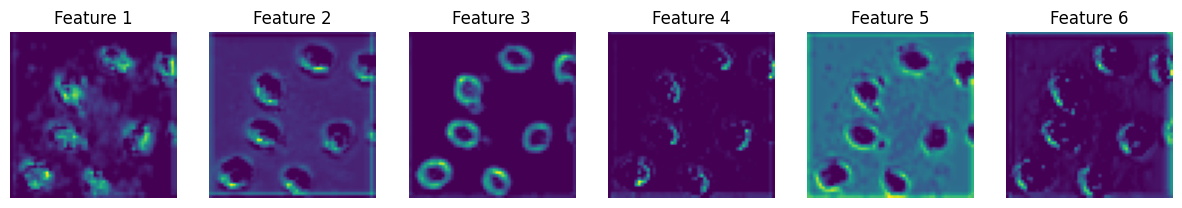

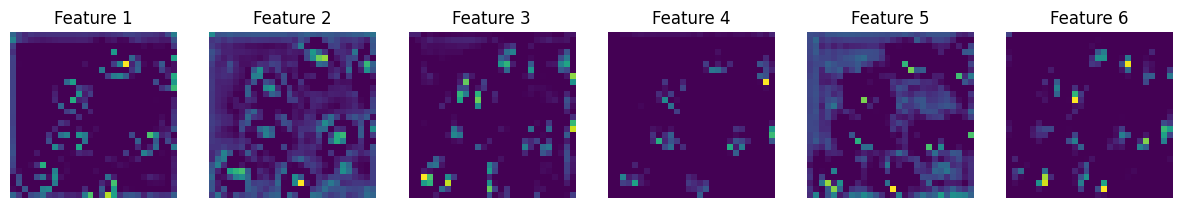

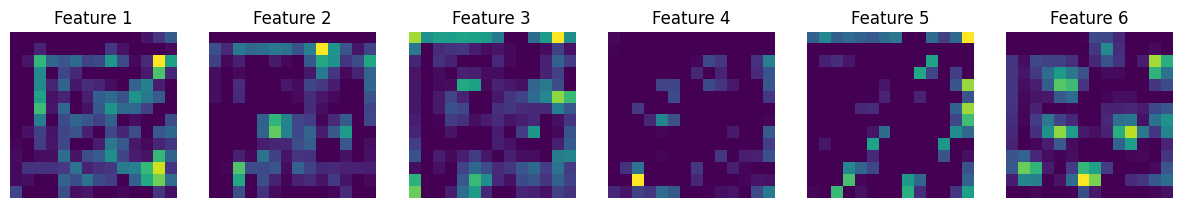

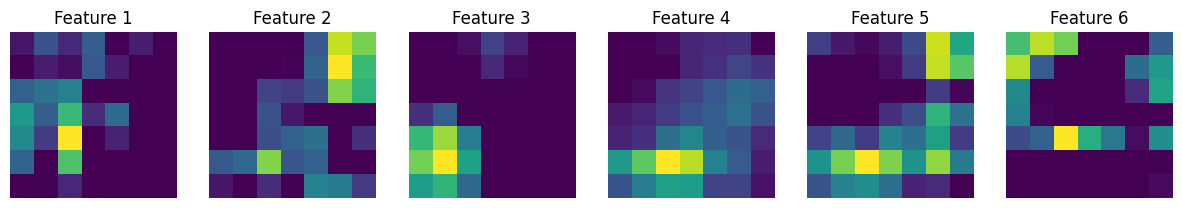

Visualizing feature maps for class 1


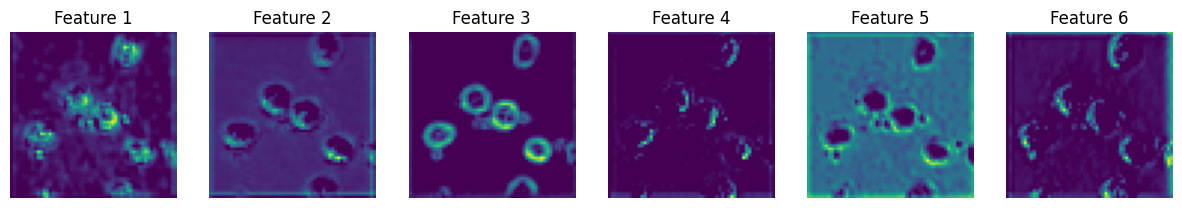

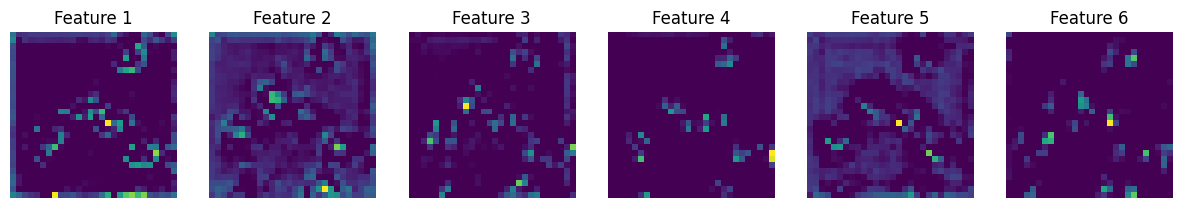

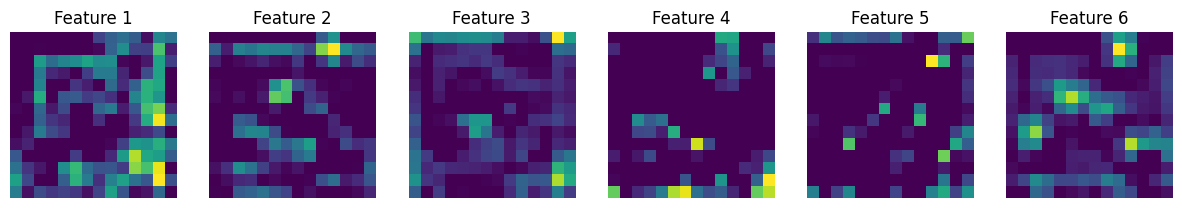

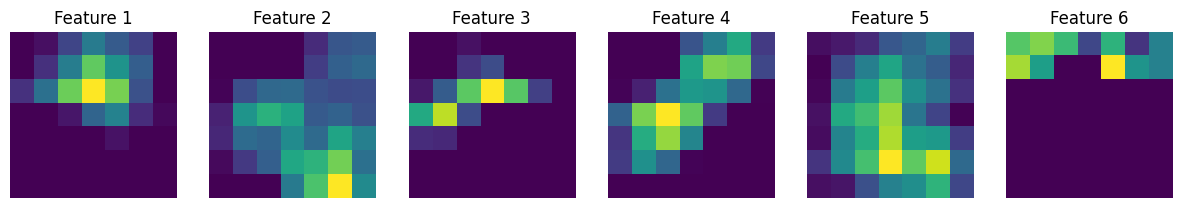

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model_pre' is your trained ResNet model and 'images' is your input batch
from torchvision.models.feature_extraction import create_feature_extractor

# Define the layers you want to extract features from
return_nodes = {'layer1': 'feature1','layer2': 'feature2','layer3': 'feature3', 'layer4': 'feature4'}
feature_extractor = create_feature_extractor(model_pre, return_nodes=return_nodes)

# Pass a batch of images through the model
with torch.no_grad():
    features = feature_extractor(images.to(device))
    print(features['feature4'].shape)  # Print shape of layer4 feature maps

# Visualize the feature maps of a given layer for a specific class in the batch
def visualize_feature_maps(features, layer_name='feature4', num_features=6, class_index=None):
    # Get the feature map for the specified layer
    feature_map = features[layer_name]

    # If class_index is specified, select the corresponding class
    if class_index is not None:
        feature_map = feature_map[class_index:class_index+1]  # Select the feature map for the specific class

    # Convert the feature map to numpy
    feature_map = feature_map.cpu().numpy()

    # Select a few feature maps (usually the first 6 feature maps)
    num_features = min(num_features, feature_map.shape[1])

    # Create subplots to display the feature maps
    plt.figure(figsize=(15, 15))
    for i in range(num_features):
        plt.subplot(1, num_features, i + 1)
        plt.imshow(feature_map[0, i, :, :], cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature {i+1}')

    plt.show()

# Visualize the feature maps from 'layer4' for each class
class_indices = [0, 1]  # Assume class 0 is "cat" and class 1 is "dog"

for class_index in class_indices:
    print(f'Visualizing feature maps for class {class_index}')
    visualize_feature_maps(features, 'feature1', class_index=class_index)
    visualize_feature_maps(features, 'feature2', class_index=class_index)
    visualize_feature_maps(features, 'feature3', class_index=class_index)
    visualize_feature_maps(features, 'feature4', class_index=class_index)


To analyze the model’s performance in classifying arsenic-treated versus non-arsenic-treated cells,
we visualized the feature maps generated during the model’s prediction process. Feature maps
represent the regions in the image that the model focuses on when making a classification decision,
providing insights into the underlying patterns the model learns.
The feature maps reveal clear differences between the two classes. For
Class 1 (not exposed to arsenic), the maps show distinct and high-intensity regions, especially in the
earlier layers of the model. This indicates that the network is able to detect well-defined structures
or features in these images. In contrast, for Class 0 (exposed to arsenic), the feature maps appear
less defined and more diffused.
In terms of spatial patterns, the activations for Class 1 are more localized and consistent, particularly
in the top rows of the maps. This implies that the model is focusing on specific areas of importance
in the non-arsenic-treated samples. On the other hand, the activations for Class 0 are more scattered
and uneven, reflecting a loss of uniformity or distinct features, likely due to the effects of arsenic.
The strong and clear activations in Class 1 suggest that the model is capturing the higher density of
PML bodies within the nucleus, which contributes to these intense activations. In comparison, the
diffused and dispersed patterns in Class 0 may indicate that arsenic exposure reduces the number of
PML bodies in the nucleus, leading to less defined patterns in the feature maps. Based on statistical
analysis, we observed that non-arsenic-treated cells exhibit a higher average density of PML bodies
compared to arsenic-treated cells. This supports the model’s predictions, as it is classifying the
images based on meaningful and legitimate features.

(-0.5, 6.5, 6.5, -0.5)

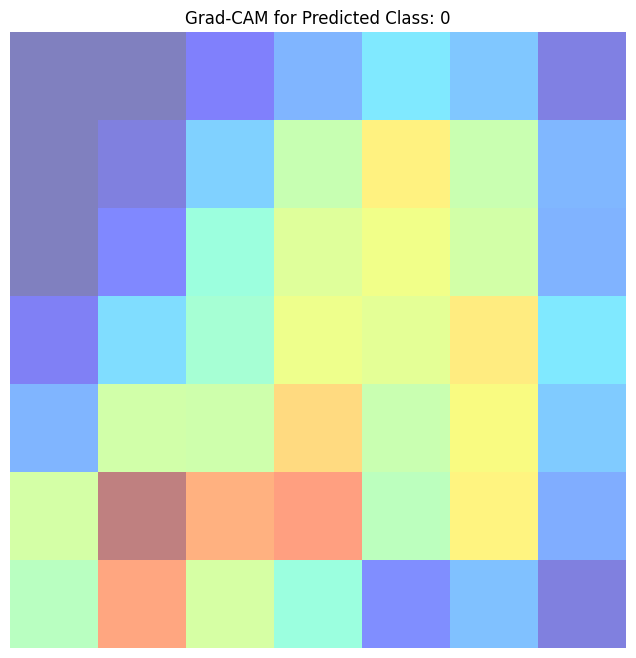

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming model_pre is your trained model (ResNet18 or similar)
model_pre.eval()

# Define hook to capture feature maps and gradients
def hook_fn(module, input, output):
    feature_maps.append(output)
    output.register_hook(save_gradient)

def save_gradient(grad):
    gradients.append(grad)

# Feature maps and gradients lists to store activations and gradients
feature_maps = []
gradients = []

# Hook into the last convolutional block (typically layer4 for ResNet18)
model_pre.layer4[1].register_forward_hook(hook_fn)

# Example: Get a batch of images from your dataset (adjust based on your dataset)
image, _ = next(iter(test_loader))  # Grab a batch of images
image = image[0].unsqueeze(0)  # Take the first image from the batch and unsqueeze to add batch dimension
image = image.to(device)

# Forward pass to get the model's output
output = model_pre(image)
pred_class = output.argmax(dim=1)  # Predicted class for the current image

# Generate Grad-CAM for the predicted class
def generate_gradcam_for_class(class_idx):
    # Get the class score for the given class
    output_class = output[:, class_idx]

    # Backpropagate the class score
    model_pre.zero_grad()
    output_class.backward()

    # Extract gradients
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])  # Pool gradients over spatial locations

    # Weight feature maps with the gradients
    feature_map = feature_maps[0][0]
    for i in range(len(pooled_gradients)):
        feature_map[i, :, :] *= pooled_gradients[i]

    # Create a heatmap by averaging the weighted feature maps
    heatmap = torch.mean(feature_map, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU to keep only positive values
    heatmap /= np.max(heatmap)  # Normalize the heatmap

    return heatmap

# Generate Grad-CAM for the predicted class (e.g., for class index 0)
heatmap_pred_class = generate_gradcam_for_class(pred_class.item())

# Visualize the heatmap for the predicted class
plt.figure(figsize=(8, 8))
plt.imshow(heatmap_pred_class, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM for Predicted Class: {pred_class.item()}")
plt.axis('off')





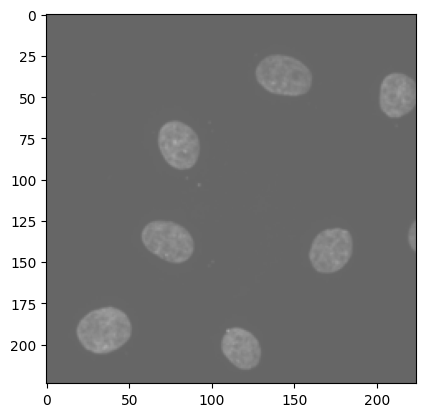

In [38]:
# Optionally: Visualize the original image
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0), alpha=0.6)
plt.show()

(-0.5, 6.5, 6.5, -0.5)

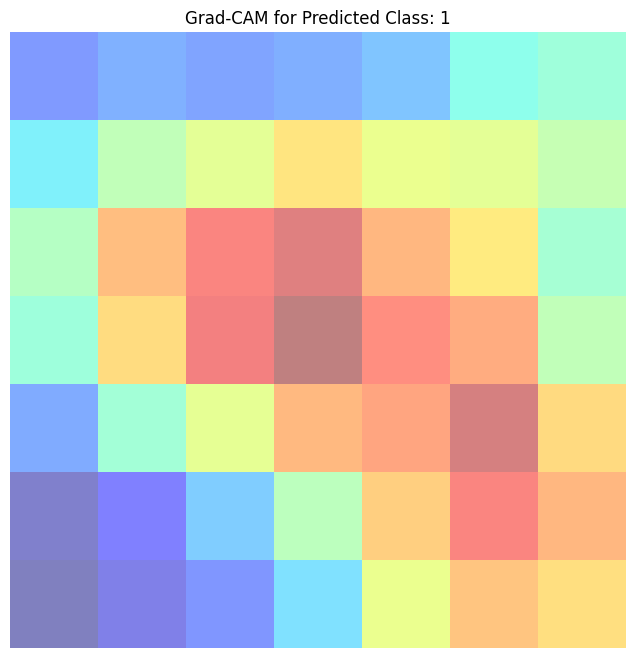

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming model_pre is your trained model (ResNet18 or similar)
model_pre.eval()

# Define hook to capture feature maps and gradients
def hook_fn(module, input, output):
    feature_maps.append(output)
    output.register_hook(save_gradient)

def save_gradient(grad):
    gradients.append(grad)

# Feature maps and gradients lists to store activations and gradients
feature_maps = []
gradients = []

# Hook into the last convolutional block (typically layer4 for ResNet18)
model_pre.layer4[1].register_forward_hook(hook_fn)

# Example: Get a batch of images from your dataset (adjust based on your dataset)
image, _ = next(iter(train_loader))  # Grab a batch of images
image = image[0].unsqueeze(0)  # Take the first image from the batch and unsqueeze to add batch dimension
image = image.to(device)

# Forward pass to get the model's output
output = model_pre(image)
pred_class = output.argmax(dim=1)  # Predicted class for the current image

# Generate Grad-CAM for the predicted class
def generate_gradcam_for_class(class_idx):
    # Get the class score for the given class
    output_class = output[:, class_idx]

    # Backpropagate the class score
    model_pre.zero_grad()
    output_class.backward()

    # Extract gradients
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])  # Pool gradients over spatial locations

    # Weight feature maps with the gradients
    feature_map = feature_maps[0][0]
    for i in range(len(pooled_gradients)):
        feature_map[i, :, :] *= pooled_gradients[i]

    # Create a heatmap by averaging the weighted feature maps
    heatmap = torch.mean(feature_map, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU to keep only positive values
    heatmap /= np.max(heatmap)  # Normalize the heatmap

    return heatmap

# Generate Grad-CAM for the predicted class (dynamic)
heatmap_pred_class = generate_gradcam_for_class(pred_class.item())

# Visualize the heatmap for the predicted class
plt.figure(figsize=(8, 8))
plt.imshow(heatmap_pred_class, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM for Predicted Class: {pred_class.item()}")
plt.axis('off')




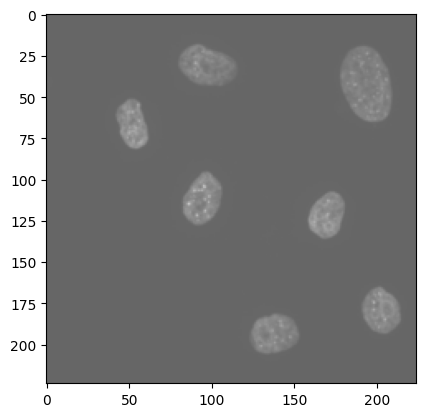

In [40]:
# Optionally: Visualize the original image (resize it to match the heatmap)
# Convert image tensor to numpy array for display
original_image = image[0].cpu().detach().numpy().transpose(1, 2, 0)
plt.imshow(original_image, alpha=0.6)
plt.show()

the Grad-CAM visualizations show that the model focuses on areas where PML bodies
are outside the nucleus. This matches the behavior seen in Class 0 (arsenic-treated cells), as arsenic
exposure causes PML bodies to move outside the nucleus. The highlighted areas in the Grad-CAM
heatmaps show that the model identifies this feature and uses it to classify arsenic-treated cells.
This behavior highlights the model’s ability to differentiate between arsenic-treated and non-treated
samples by focusing on meaningful changes in cellular structure. This means the model is making
predictions based on real biological changes, which supports its accuracy in identifying the effects
of arsenic on cells.